<a href="https://colab.research.google.com/github/jcmachicao/curso_intro_nn/blob/main/demo_tensorboard_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo Tensorboard

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!pip uninstall -q tensorboard tb-nightly
!pip install -q tb-nightly

Proceed (y/n)? y
     |████████████████████████████████| 5.6 MB 5.6 MB/s 


In [3]:
%pylab inline
import torch
%load_ext tensorboard

Populating the interactive namespace from numpy and matplotlib


In [4]:
import tempfile
import torch.utils.tensorboard as tb 
import tempfile
log_dir = tempfile.mkdtemp()

In [6]:
# crea el operador de transformación de data: transform
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Genera el trainset y testset del dataset elegido
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# genera los dataloaders para training y testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# define las clases: classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [7]:
# Define la función para visualizar imágenes (se usa en `plot_classes_preds`)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
#@title Arquitectura
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
%tensorboard --logdir {log_dir} --reload_interval 1
logger = tb.SummaryWriter(log_dir + '/test', flush_secs=1)

<IPython.core.display.Javascript object>

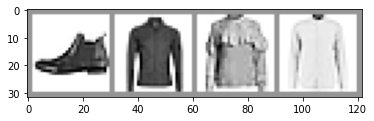

In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images and write to tensorboard
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
logger.add_image('four_fashion_mnist_images', img_grid)

In [12]:
logger.add_graph(net, images)
logger.close()

In [13]:
# helper functions

def images_to_probs(net, images):
    '''
    Genera predicciones y probabilidades de la red de entrenamiento
    y su lista de imágenes asociadas
    '''
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Genera la figura matplotlib de la red de entrenamiento, con las imágenes
    y etiquetas de un batch, esto muestra las predicciones top con sus probabilidades
    para cada etiqueta, coloreando la información basada en la corrección de la
    predicción. Usa la función ´images_to_probes´
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [14]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            logger.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            logger.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


https://pytorch.org/tutorials/intermediate/tensorboard_tutorial

https://www.youtube.com/watch?v=n8lf-Nu3i-c

# Arquitecturas alternativas clasificación regresión

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_cols, 128)
    self.fc3 = nn.Linear(128, 16)
    self.fc4 = nn.Linear(16, n_cats)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dp1(F.relu(self.fc2(x)))
    x = self.dp1(F.relu(self.fc3(x)))
    x = self.fc4(x)

    return F.log_softmax(x, dim=1)

model = Net()

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_cols, 128)
    self.fc3 = nn.Linear(128, 16)
    self.fc4 = nn.Linear(16, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dp1(F.relu(self.fc2(x)))
    x = self.dp1(F.relu(self.fc3(x)))
    x = self.fc4(x)

    return x

model = Net()